In [52]:
import os
import time

import numpy as np
import scipy as sp
import bottleneck as bn

import math
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [53]:
# randomize parameters 
N = 1000
M = 20

# smoothness of the sensitivity
std_dev = 0.02

# coupon's face value limits
bj_min = 0.6   
bj_max = 0.6 + (M-1) * 0.1

bj = np.linspace(bj_min, bj_max, M)

# sensitivity limits
pij_low_min = 0.0
pij_low_max = 0.8

pij_hig_min = 0.2
pij_hig_max = 0.99

In [54]:
def linear_fun(x, x1, y1, x2, y2):
    """
    linear function (x1, y1) and (x2, y2)
    """
    slope = (y2 - y1) / (x2 - x1)

    return slope * (x - x1) + y1

In [55]:
def log_fun(x, x1, y1, x2, y2):
    """
    logarithmic function (x1, y1) and (x2, y2)
    """
    a = (y2 - y1) / (math.log(x2) - math.log(x1))
    b = y1 - a * math.log(x1)

    return a * np.log(x) + b

In [56]:
def describe_log_function(x1, y1, x2, y2):
    # Calculate the constants a and b
    a = (y2 - y1) / (math.log(x2) - math.log(x1))
    b = y1 - a * np.log(x1)
    
    return a, b

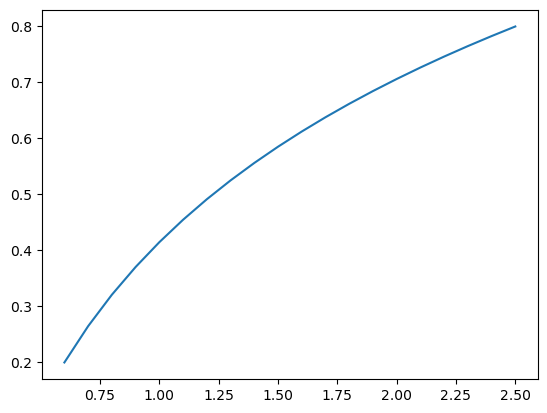

In [57]:
p = log_fun(bj, bj_min, 0.2, bj_max, 0.8)

plt.plot(bj, p)

In [58]:
def mono_fun(x, x1, y1, x2, y2):
    """
    construct a monotonoically increaseing function
    between (x1, y1) and (x2, y2)
    """
    funs = {
        "linear_fun": linear_fun,
        "log_fun": log_fun
    }

    rnd_name = random.choice(list(funs.keys()))
    rnd_fun = funs[rnd_name]

    return rnd_fun(x, x1, y1, x2, y2)

In [59]:
def noiser(x, n, std_dev):
    """
    Add the noise to the function.
    """
    return x + np.random.normal(0.0, std_dev, n)
    


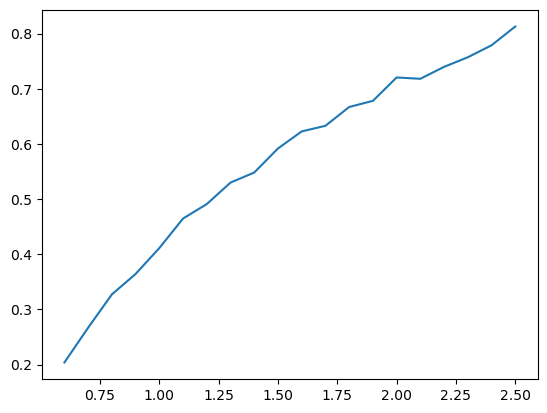

In [60]:
pij = mono_fun(bj, bj_min, 0.2, bj_max, 0.8)

pij = noiser(pij,M, 0.01)
plt.plot(bj, pij)
plt.show()

In [72]:
pijs = []

std_dev = 0.02

for i in range(N):

    pij_low = np.random.uniform(pij_low_min, pij_low_max)
    a = max(pij_low,pij_hig_min)
    pij_hig = np.random.uniform(a, max(pij_hig_max,a))
    pij = mono_fun(bj, bj_min, pij_low, bj_max, pij_hig)
    pij = noiser(pij,M, std_dev)

    pijs.append(pij)

pijs = np.array(pijs)


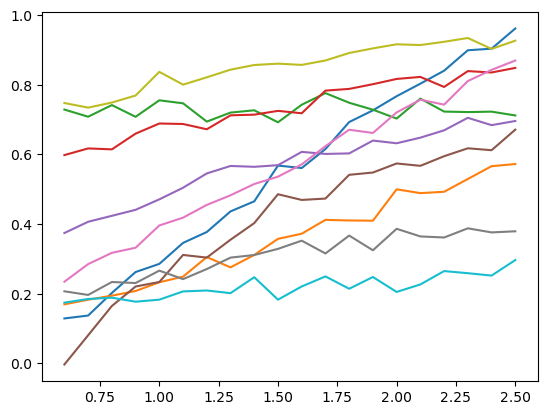

In [89]:
nplots = np.random.randint(0, N, 10)
for i in range(len(nplots)):
    plt.plot(bj, pijs[nplots[i]])

plt.show()


In [63]:
def 
  

0.1